In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
from jp_analysis import *

import jp_mpl as jplot
import rat
from itertools import cycle
from scipy.stats import truncnorm
plt.rcParams['image.cmap'] = 'YlOrRd'

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


###  Start here if you have already loaded/selected the tracks

In [2]:
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed_337nm.pckl'))


Slice of the deepest point reflected photons touch
12728


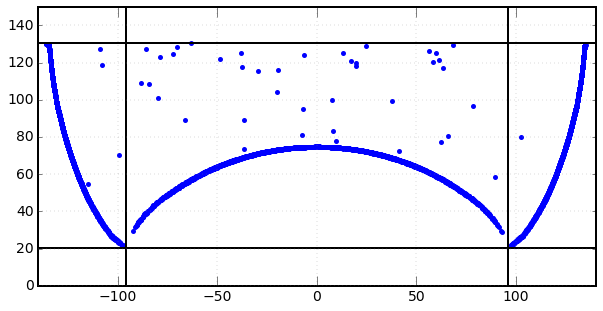

In [3]:
print 'Slice of the deepest point reflected photons touch'
yz_center = 0
tol = 10 # mm
ybool = (data['xr'][:,1] > (yz_center-tol) )*(data['xr'][:,1]< (yz_center+tol) )
print np.sum(ybool)
plt.figure(figsize=(10,5))
plt.plot(data['xr'][ybool,0], data['xr'][ybool,2], '.')
plt.xlim([-140,140])
plt.ylim(0,150)
plt.axhline(y=130.4, xmin=-140, xmax=140, color='k')
plt.axhline(y=130.4-110.3, xmin=-140, xmax=140, color='k')

pmt_radius = 192./2
plt.axvline(x=pmt_radius, ymin=0, ymax=300, color='k')
plt.axvline(x=-pmt_radius, ymin=0, ymax=300, color='k')

#plt.axhline(y=115, xmin=-140, xmax=140, color='k')
#plt.axhline(y=265, xmin=-140, xmax=140, color='k')
#plt.ylim(60, 65)

In [4]:
# Only focus on photons reflected at PMT/concentrator - nothing deeper
ibool = data['xr'][:,2] > (130.4-110.3)

# Now let's pick pmt reflections
reflect_pmt = (np.sqrt(np.sum(data['xr'][:,:2]**2,axis=1)) < pmt_radius)*ibool
reflect_conc = (np.sqrt(np.sum(data['xr'][:,:2]**2,axis=1)) > pmt_radius)*ibool

print np.sum(reflect_pmt), np.sum(reflect_conc)

18992 188065


Slice of the deepest point reflected photons touch
126529


(20, 140)

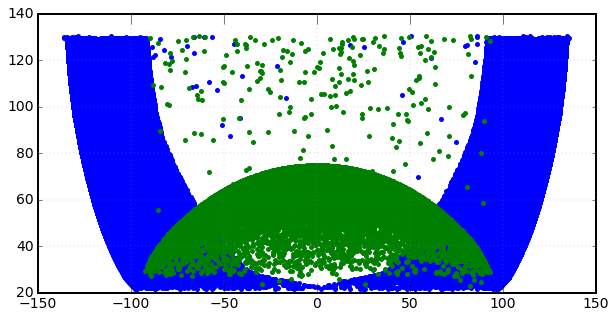

In [5]:
print 'Slice of the deepest point reflected photons touch'
yz_center = 0
tol = 100 # mm
ybool = (data['xr'][:,1] > (yz_center-tol) )*(data['xr'][:,1]< (yz_center+tol) )
print np.sum(ybool)
plt.figure(figsize=(10,5))
plt.plot(data['xr'][ybool*reflect_conc,0], data['xr'][ybool*reflect_conc,2], '.b')
plt.plot(data['xr'][ybool*reflect_pmt,0], data['xr'][ybool*reflect_pmt,2], '.g')

plt.xlim([-150,150])
plt.ylim(20,140)



In [6]:
# For all the stored photons, I know who reflected them
# Can I use my ellipsoid formula to find out?

def pmtContactTime( x0, y0, z0, u, v, w):
    # x0, y0, z0 are the starting point
    # u, v, w are the velocity components
    # ae, ce are ellipsoid characteristics
    ae = 203.7/2.
    ce = 150.3/2.
    a = w**2 / ce**2 + (u**2+v**2)/ae**2
    b = 2*((u*x0+v*y0)/ae**2 + w*z0/ce**2)
    c = (x0**2 + y0**2)/ae**2 + z0**2/ce**2 -1
    
    inner_sqrt = b**2 -4*a*c
    #print inner_sqrt
    if inner_sqrt < 0:
        return 0.
    
    sol1 = (-b+np.sqrt(inner_sqrt))/(2*a)
    sol2 = (-b-np.sqrt(inner_sqrt))/(2*a)
    
    if sol1 > 0 and sol2 < 0:
        return sol1
    if sol2 > 0 and sol1 < 0:
        return sol2
    if sol1 > 0 and sol2 > 0:
        return np.min([sol1, sol2])
    if sol1 < 0 and sol2 < 0:
        return 0.
    
    
    

def pmtContactDepth(z0, w, t):
    return z0 + t*w

In [7]:
data.keys()

['theta_f',
 'y',
 'delta_t',
 'phi_f',
 'theta_i',
 'xr',
 'r',
 'phidiff',
 'phi_i',
 'x',
 'nsteps',
 'momentum']

In [8]:
# The momentum is not a unit vector. Don't know why. Renormalizing it
momentum_norm = np.linalg.norm(data['momentum'],axis=1)
momentum_norm = momentum_norm.reshape(momentum_norm.size, 1)
data['momentum'] /= momentum_norm
my_times = np.zeros_like(data['r'])
my_z     = np.zeros_like(my_times)
for ievent in range(len(data['r'])):
    x0 = data['x'][ievent]
    y0 = data['y'][ievent]
    z0 = 130.4

    u = data['momentum'][ievent,0]
    v = data['momentum'][ievent,1]
    w = data['momentum'][ievent,2]
    t = pmtContactTime(x0,y0,z0, u,v,w)
    z = pmtContactDepth(z0, w, t)
    my_times[ievent] = t
    my_z[ievent] = z

/home/jp/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6365: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


18.5
Everything below 26mm actually hit the concentrator


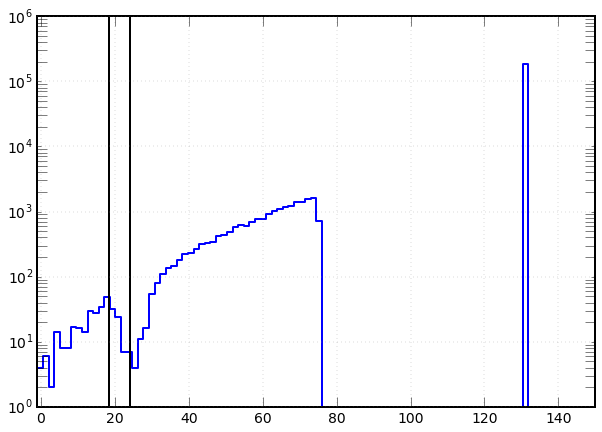

In [9]:
plt.figure(figsize=(10,7))
xaxis = np.linspace(-1, 150, 101)
b, x = np.histogram(my_z, xaxis)
jplot.unfilledBar(x,b)
plt.yscale('log')
plt.axvline(131.8-113.3, 0.001, 1000, color='k')
plt.axvline(24, 0.001, 1000, color='k')
print 131.8-113.3
print 'Everything below 26mm actually hit the concentrator'

In [10]:
pmt_hits = (my_z < 100)*(my_z > 24.)
conc_hits = (my_z > 100)+(my_z < 24)

print 'PMT hits', np.sum(pmt_hits)
print 'Concentrator hits', np.sum(conc_hits)


PMT hits 19850
Concentrator hits 187210


In [11]:
mismatch = pmt_hits != reflect_pmt
print np.sum(mismatch)

1194


Slice of the deepest point reflected photons touch


(-150, 150)

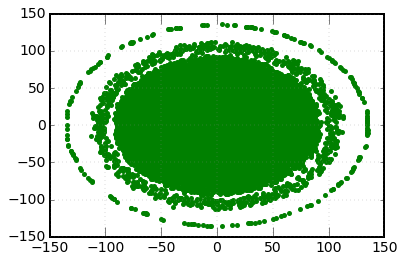

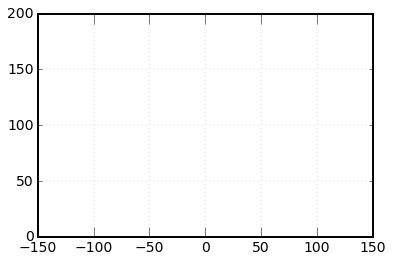

In [12]:
print 'Slice of the deepest point reflected photons touch'
mybool = mismatch
plt.figure()
plt.plot(data['xr'][pmt_hits,0], data['xr'][pmt_hits,1], '.g')
#plt.plot(data['xr'][reflect_pmt,1], data['xr'][reflect_pmt,2], '.r')
#plt.plot(data['xr'][conc_hits,1], data['xr'][conc_hits,2], '.y')
#plt.plot(data['xr'][reflect_conc,1], data['xr'][reflect_conc,2], '.c')

#plt.plot(data['xr'][mybool,1], data['xr'][mybool,2], '.')

plt.ylim(-150,150)
plt.xlim(-150,150)

plt.figure()

#plt.plot(data['xr'][conc_hits,1], data['xr'][conc_hits,0], '.y')
#plt.plot(data['xr'][mybool,1], data['xr'][mybool,0], '.')
plt.ylim(0,200)
plt.xlim(-150,150)


In [13]:
print 'Mismatches are due to the exact size of the grey disc'
print 'The current implementation is a good classifier of PMT vs PETAL hit'

Mismatches are due to the exact size of the grey disc
The current implementation is a good classifier of PMT vs PETAL hit


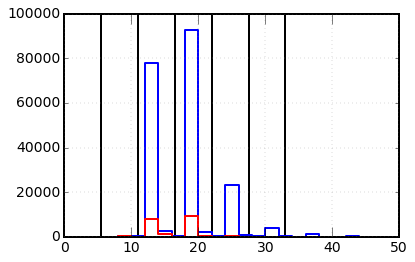

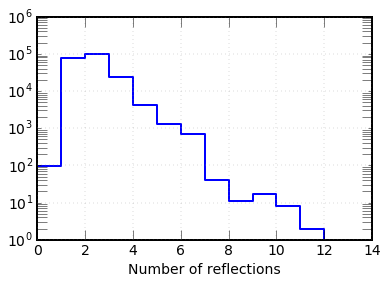

In [14]:
plt.figure()
b, x = np.histogram(data['nsteps'], np.arange(0, 50, 2))
b2, x = np.histogram(data['nsteps'][reflect_pmt], x)
for i in range(7):
    plt.axvline(5.5*i, 0, 45000, color = 'k')
jplot.unfilledBar(x,b)
jplot.unfilledBar(x,b2, color='red')

plt.xlim(0, 50)

plt.figure()
b,x = np.histogram(np.ceil(data['nsteps']/7)-1, np.arange(0, 15, 1))
jplot.unfilledBar(x,b)
plt.yscale('log')
plt.ylim(1, 1E6)
plt.xlabel('Number of reflections')

In [20]:
data['nsteps'] = np.ceil(data['nsteps']/7)-1

In [30]:
# Change the theta to do it as a function of cos(theta) - it might show up more interesting correlations
gdr = 138.
def plotReflections(data, sel):
    fig = plt.figure(figsize=(16,14))

    ### First figure - incoming vs diff
    ax1 = fig.add_subplot(221)

    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Outgoing theta - incoming')
    #plt.yticks(np.arange(-90, 90, 5.0))

    
    
    ### Second figure - function of radius and incoming theta
    #ax2 = fig.add_subplot(222)
    #x1 = np.linspace(0, gdr, 41)
    #x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    #n, x1, x2 = np.histogram2d(data['r'][sel], 
    #                           data['theta_f'][sel] - data['theta_i'][sel], 
    #                           [x1,x2])
    #n = renormN(n,axis=1)
    #plt.pcolor(x1,
    #           np.rad2deg(x2),
    #           n.T)
    #plt.xlabel('Radius (mm)')
    #plt.ylabel('theta_f - theta_i (deg)')
    #plt.colorbar()
    #plt.title('Theta difference vs radius')
    
    
    
    #ax2 = fig.add_subplot(222)
    #yvalues = data['theta_i'][sel]
    #xvalues = data['r'][sel]
    #x1 = np.linspace(0, gdr, 41)
    #x2 = np.linspace(0, np.pi/2., 51)
    #b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2],
    #                       weights=np.cos(data['theta_f'][sel]) - np.cos(data['theta_i'][sel]))
    #b2,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
    #plt.pcolor(np.rad2deg(x2),x1,b/(b2+0.1),cmap='RdBu', vmin=-1,vmax=1)
    #plt.colorbar()
    #plt.xlabel('theta_i')
    #plt.ylabel('Radius (mm)')
    #plt.title('Delta theta as function of radius & incoming theta')
    
    ax2 = fig.add_subplot(222)
    time_axis = np.linspace(0., 5., 61)
    b, x = np.histogram(data['delta_t'][sel], time_axis)
    b = b*1./b.max()
    jplot.unfilledBar(x,b)
    
    cumsumb = np.cumsum(b)*b.max()/b.sum()
    jplot.unfilledBar(x, cumsumb, color='k')
    
    plt.xlabel('Delta t (ns)')
    plt.ylabel('Photons (arbitrary scaling)')
    try:
        plt.yscale('log')
        #plt.ylim([0.99, 1.])
        plt.axhline(y=0.999, xmin=0, xmax=10)
    except:
        print 'Uuuups! No log scale figure'
    
    
    
    ### Third figure - cos(theta) incoming vs outgoing
    ax3 = fig.add_subplot(223)
    x1 = np.linspace(0, np.pi/2, 41)
    x2 = np.linspace(-1, 1., 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               np.cos(data['theta_f'][sel])-\
                               np.cos(data['theta_i'][sel]), 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               x2,
               n.T)
    plt.xlabel('theta_i')
    plt.ylabel('np.cos(theta_f) - np.cos(theta_i)')
    plt.colorbar()
    plt.title('Outgoing theta vs radius')  
    
    # Fourth figure - function of contact position
    # The quiver function was unnecessary. Removing
    
    
    #ax4 = fig.add_subplot(224)
    #iev  = 500
    #prob = iev*1./len(sel)
    #randsel = sel*(np.random.rand(len(sel)) < prob)
    #plt.quiver(data['y'][randsel], 
    #           data['z'][randsel],
    #           np.cos(data['theta_f'][randsel]), 
    #           np.sin(data['phi_f'][randsel]))
    #plt.xlabel('y (mm)')
    #plt.ylabel('z (mm)')

    #plt.title('Outgoing theta vs radius') 
    
    ax4 = fig.add_subplot(224)
    yvalues = np.cos(data['theta_i'][sel])
    xvalues = data['r'][sel]
    x1 = np.linspace(0, gdr, 41)
    x2 = np.linspace(0, 1., 51)
    b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2],
                           weights=data['nsteps'][sel])
    b2,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
    plt.pcolor(x2,x1,b/(b2+0.1), vmin=0, vmax=2)
    plt.colorbar()
    plt.xlabel('cos(theta_i)')
    plt.ylabel('Radius (mm)')
    plt.title('Number of steps as fcn of angle & radius')
    

    # New figure - everything for phi
    fig2 = plt.figure(figsize=(16,14))

    
    ### Figure
    axb = fig2.add_subplot(221)

    x1 = np.linspace(-np.pi, np.pi, 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['phi_i'][sel], 
                               data['phidiff'][sel], [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming phi (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Outgoing phi - incoming')

    
    ## Phi change vs radius
    axb2 = fig2.add_subplot(222)
    x1 = np.linspace(0, 138., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs radius')
    
    # Phi change vs incoming theta
    axb3 = fig2.add_subplot(223)
    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs incoming theta')    
    
    # Outpgoing phi as function of radius
    #axb4 = fig2.add_subplot(224)

    
    # outgoing phi as a function of radius?
    #plt.title('Change in phi vs radius')
    #iev  = 500
    #prob = iev*1./len(sel)
    #randsel = sel*(np.random.rand(len(sel)) < prob)
    #plt.quiver(data['y'][randsel], 
    #           data['z'][randsel],
    #           np.cos(data['phi_f'][randsel] - data['phi_i'][randsel]), 
    #           np.sin(data['phi_f'][randsel] - data['phi_i'][randsel]))
    #plt.xlabel('y (mm)')
    #plt.ylabel('z (mm)')
    
    
    #axb4 = fig2.add_subplot(224)
    #yvalues = data['phi_i'][sel]
    #xvalues = data['r'][sel]
    #x1 = np.linspace(0, gdr, 41)
    #x2 = np.linspace(-np.pi, np.pi, 51)
    #b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2],
    #                       weights=data['nsteps'][sel])
    #b2,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
    #plt.pcolor(np.rad2deg(x2),x1,b/(b2+0.1),vmin=0, vmax=2)
    #plt.colorbar()
    #plt.xlabel('phi_i')
    #plt.ylabel('Radius (mm)')
    #plt.title('Number of steps as fcn of angle & radius')
    
    axb4 = fig2.add_subplot(224)
    xvalues = data['theta_i'][sel]
    yvalues = data['delta_t'][sel]
    x1 = np.linspace(0, np.pi/2., 31)
    x2 = np.linspace(0, 3., 41)
    b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
    b = renormN(b,axis=1)
    plt.pcolor(np.rad2deg(x1), x2, b.T)
    plt.colorbar()
    plt.ylabel('Delay (ns)')
    plt.xlabel('Theta in')

Selecting all the events


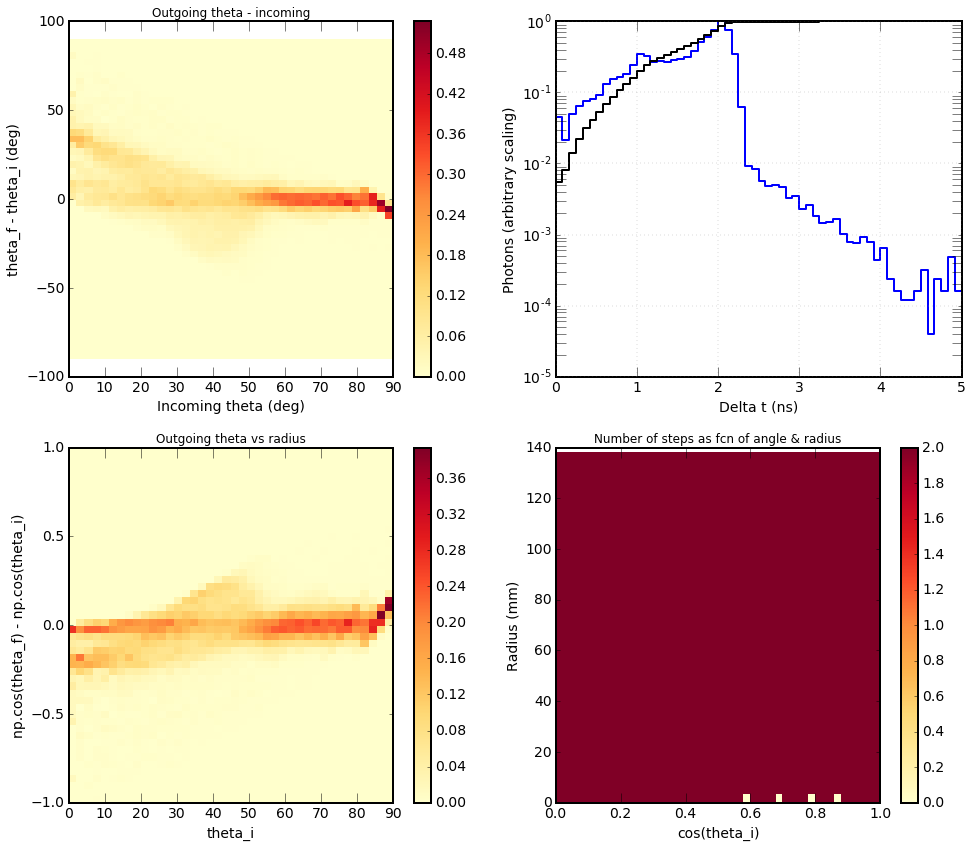

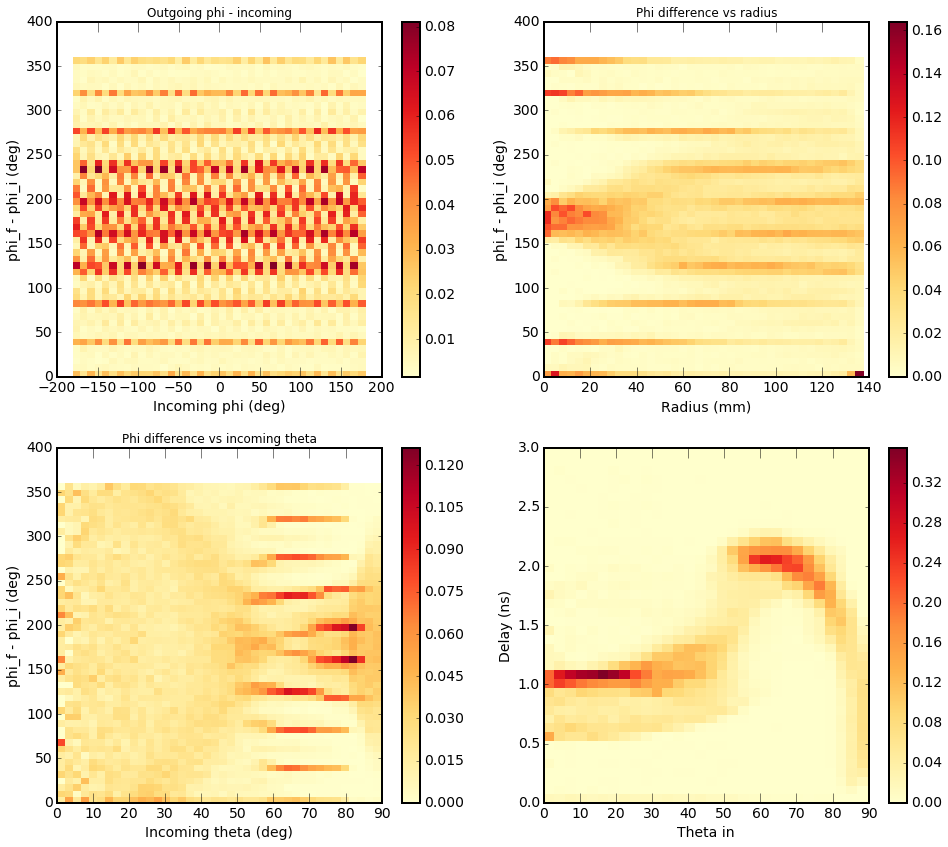

In [31]:
print 'Selecting all the events'
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting only the events that hit the PMT first


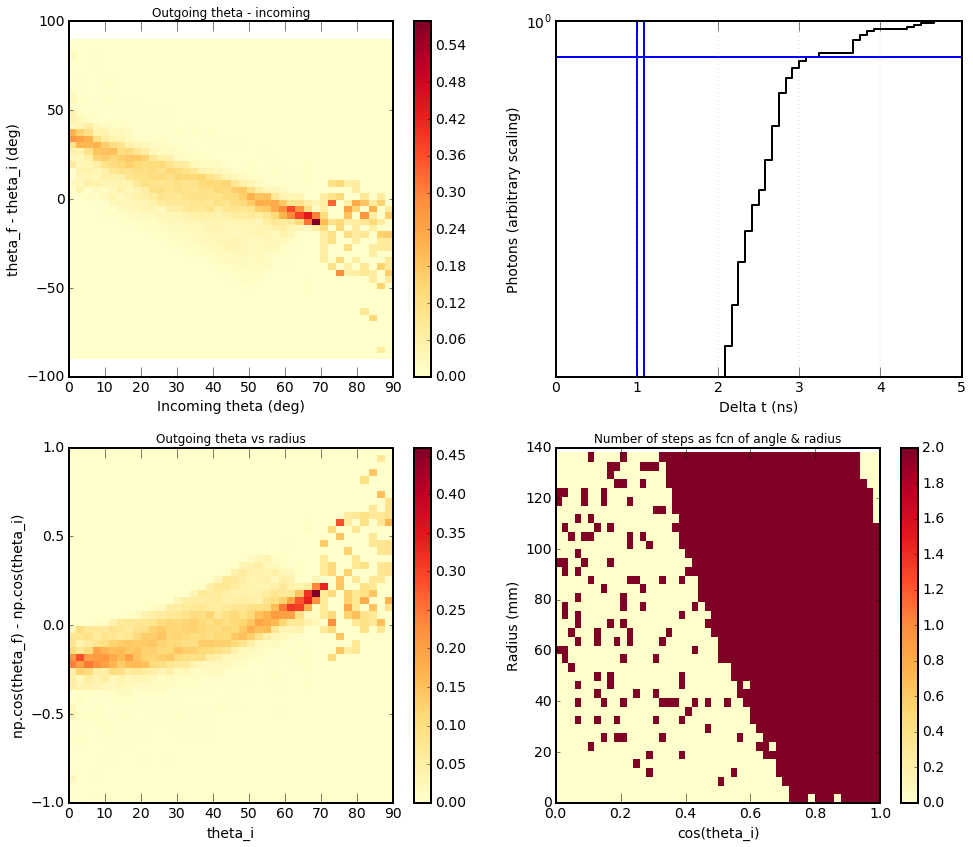

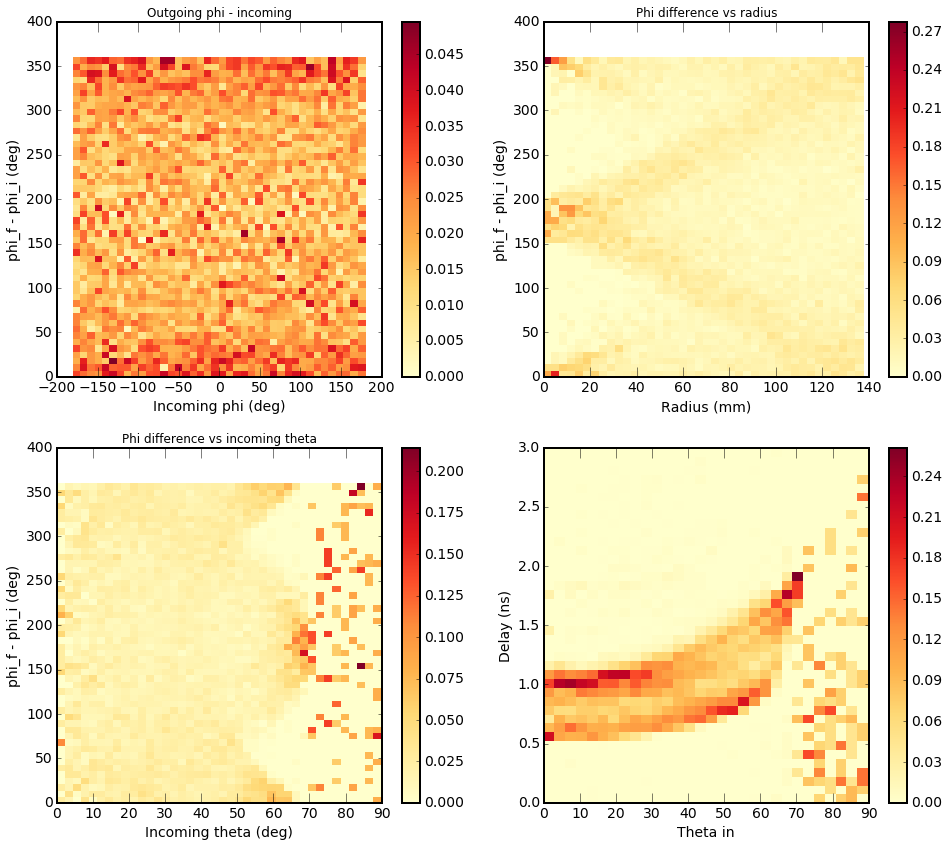

In [21]:
print 'Selecting only the events that hit the PMT first'
sel=( np.array([True]*len(data['y']))
     *reflect_pmt
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting only the events that hit the PMT and leave in a single reflection
Events  0
Uuuups! No log scale figure


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in divide


Error in callback <function post_execute at 0x7fe158d931b8> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

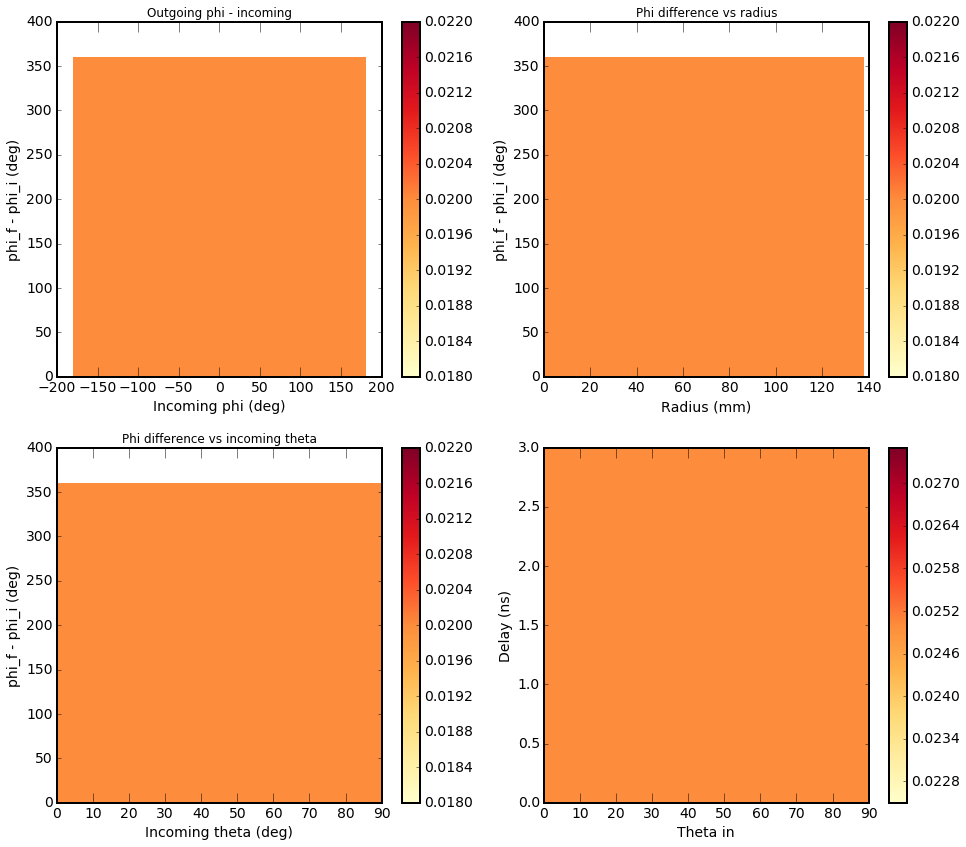

In [25]:
print 'Selecting only the events that hit the PMT and leave in a single reflection'
sel=( np.array([True]*len(data['y']))
     *reflect_pmt
     *(data['nsteps'] < 2)
     #*(data['z'] > 0)
     #*(data['r']>80)
    )
print 'Events ', np.sum(sel)
plotReflections(data,sel)

Selecting only the events that hit the PMT and leave after multiple reflections
Events  18992


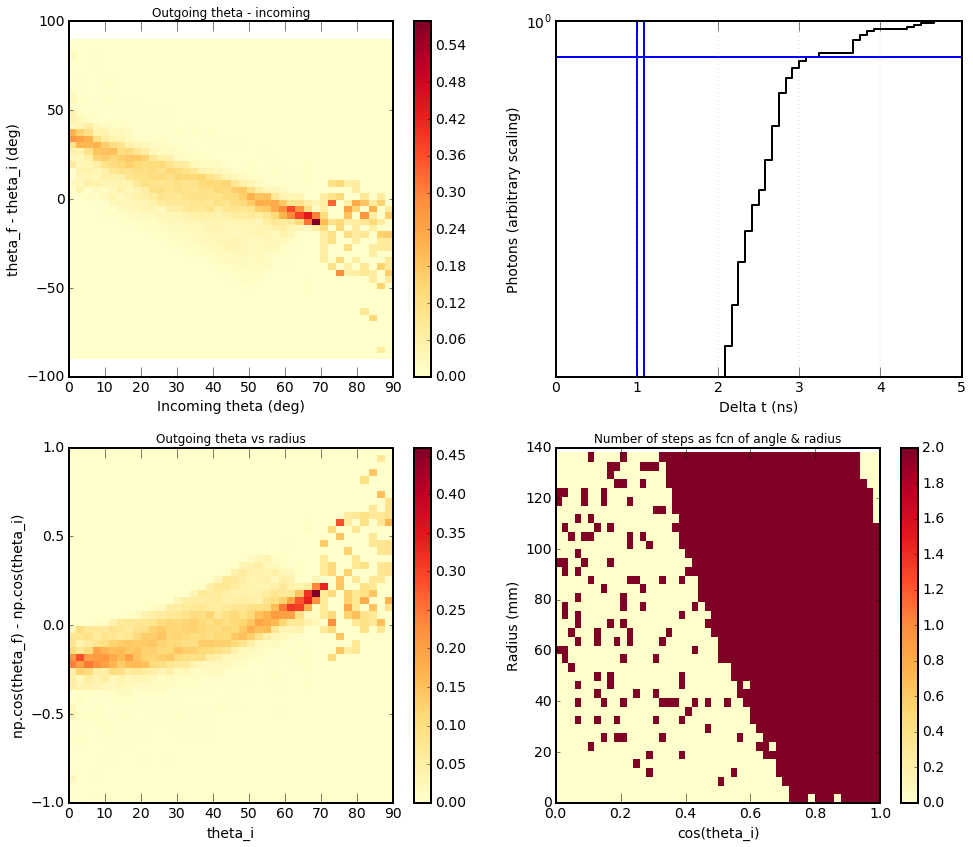

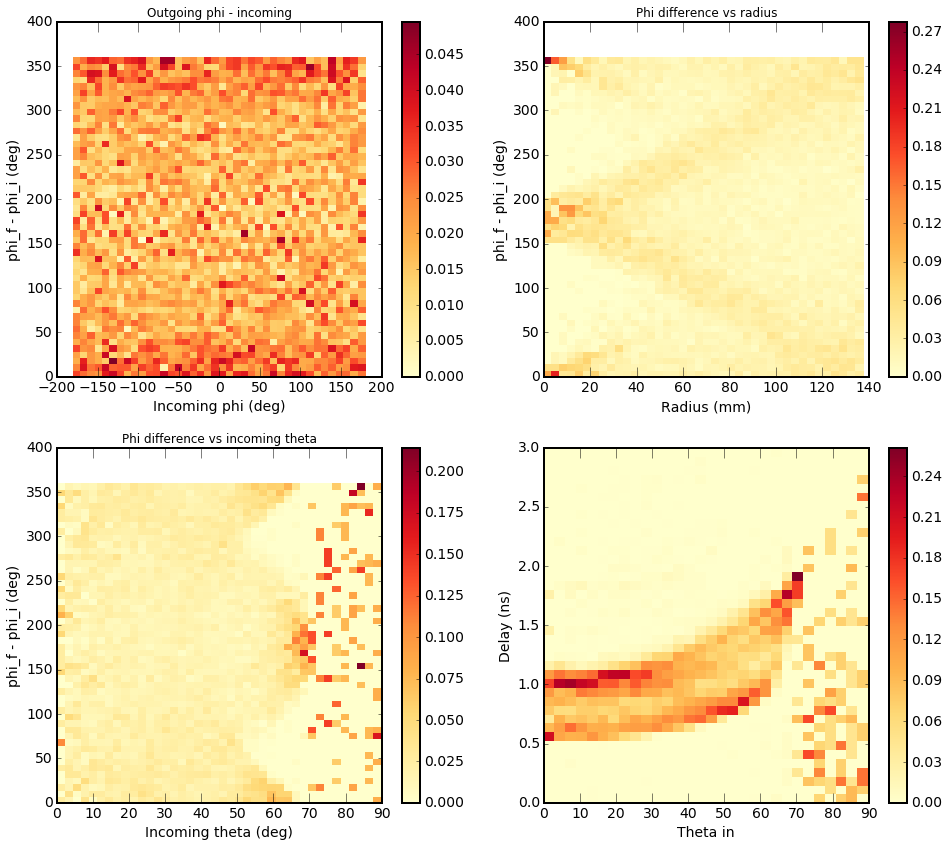

In [26]:
print 'Selecting only the events that hit the PMT and leave after multiple reflections'
sel=( np.array([True]*len(data['y']))
     *reflect_pmt
     *(data['nsteps'] > 1)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
print 'Events ', np.sum(sel)
plotReflections(data,sel)

Selecting only the events that hit the concentrator first


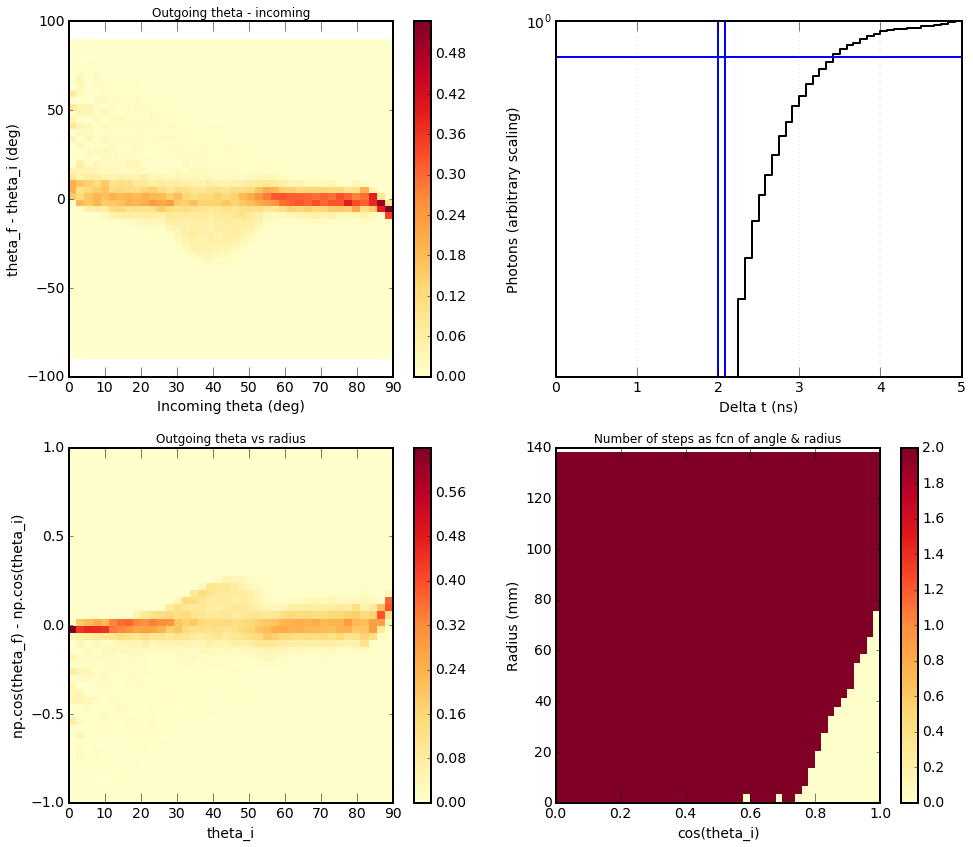

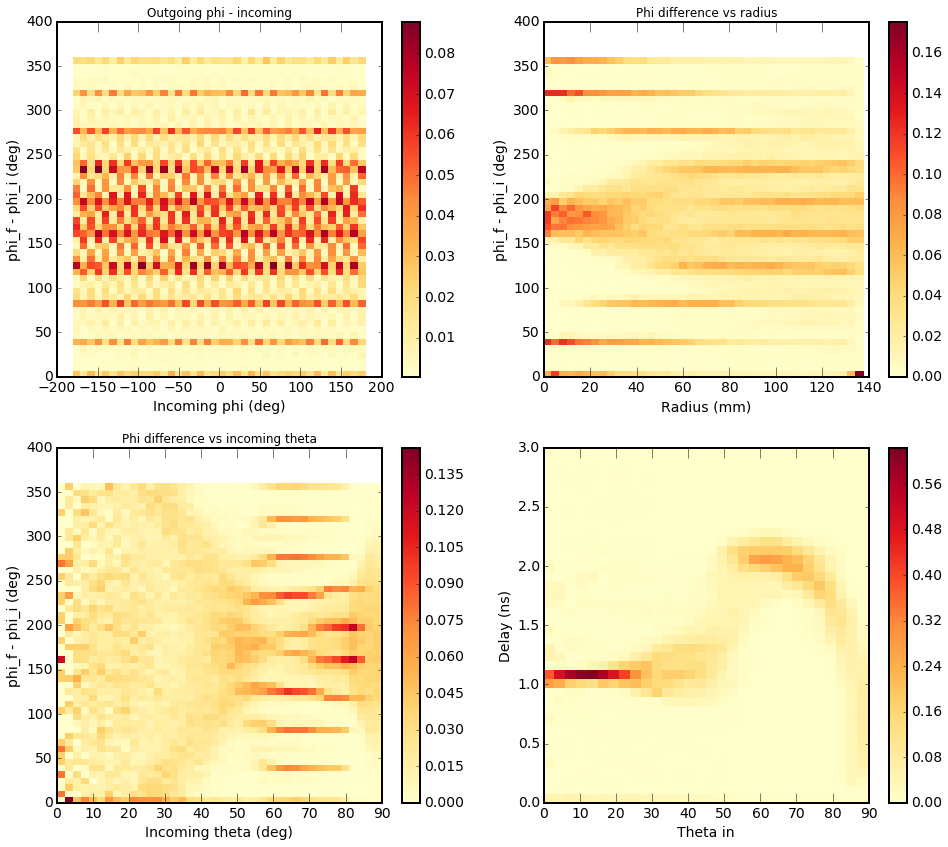

In [27]:
print 'Selecting only the events that hit the concentrator first'
sel=( np.array([True]*len(data['y']))
     *reflect_conc
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting only the events that hit the CONCENTRATOR and leave in a single reflection
Events  0
Uuuups! No log scale figure


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in divide


Error in callback <function post_execute at 0x7fe158d931b8> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

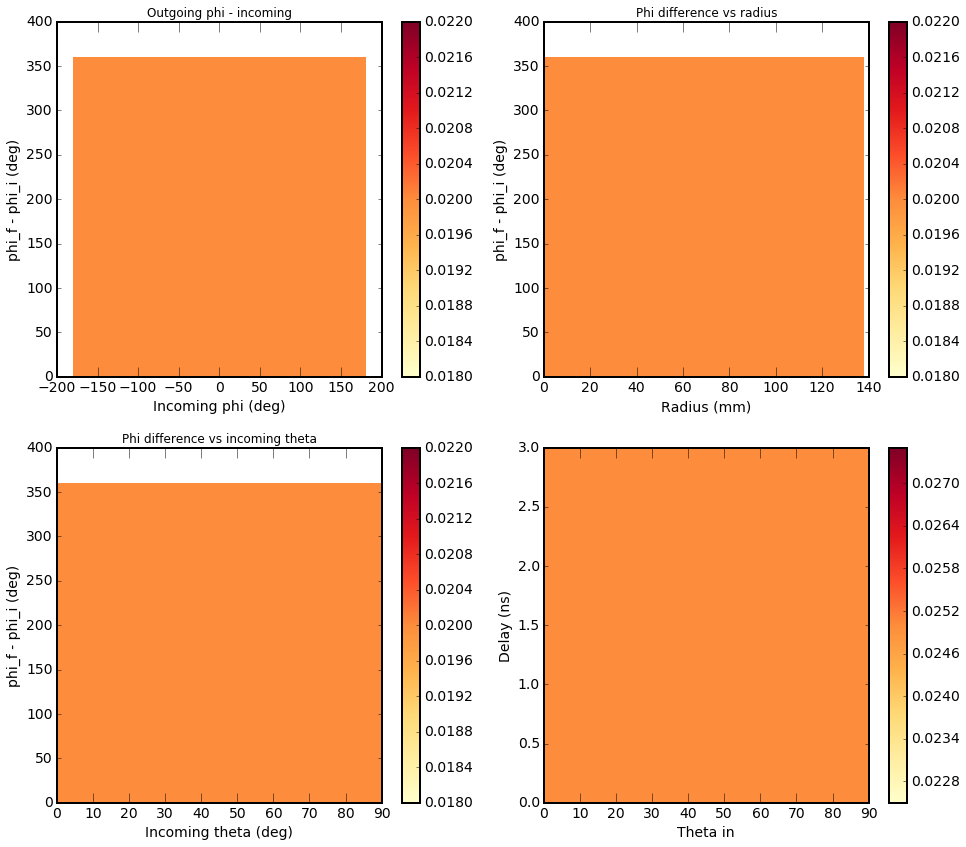

In [28]:
print 'Selecting only the events that hit the CONCENTRATOR and leave in a single reflection'
sel=( np.array([True]*len(data['y']))
     *reflect_conc
     *(data['nsteps'] < 2)
     #*(data['z'] > 0)
     #*(data['r']>80)
    )
print 'Events ', np.sum(sel)
plotReflections(data,sel)

Selecting only the events that hit the CONCENTRATOR and have multiple reflections reflection
Events  188065


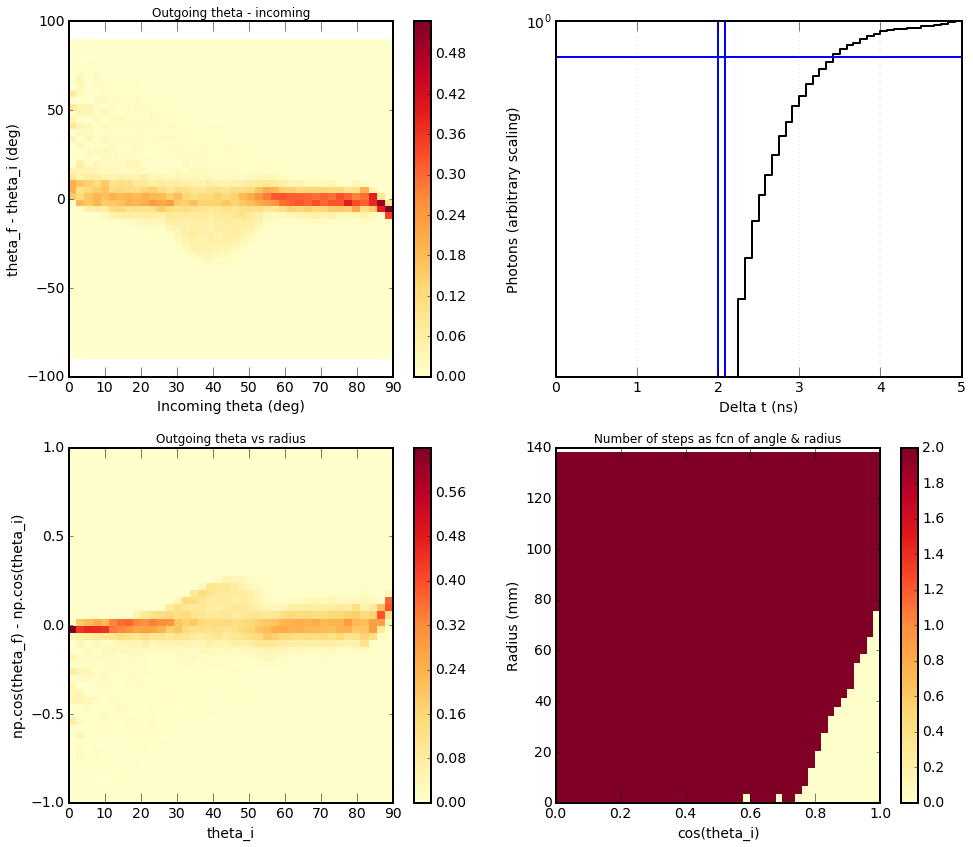

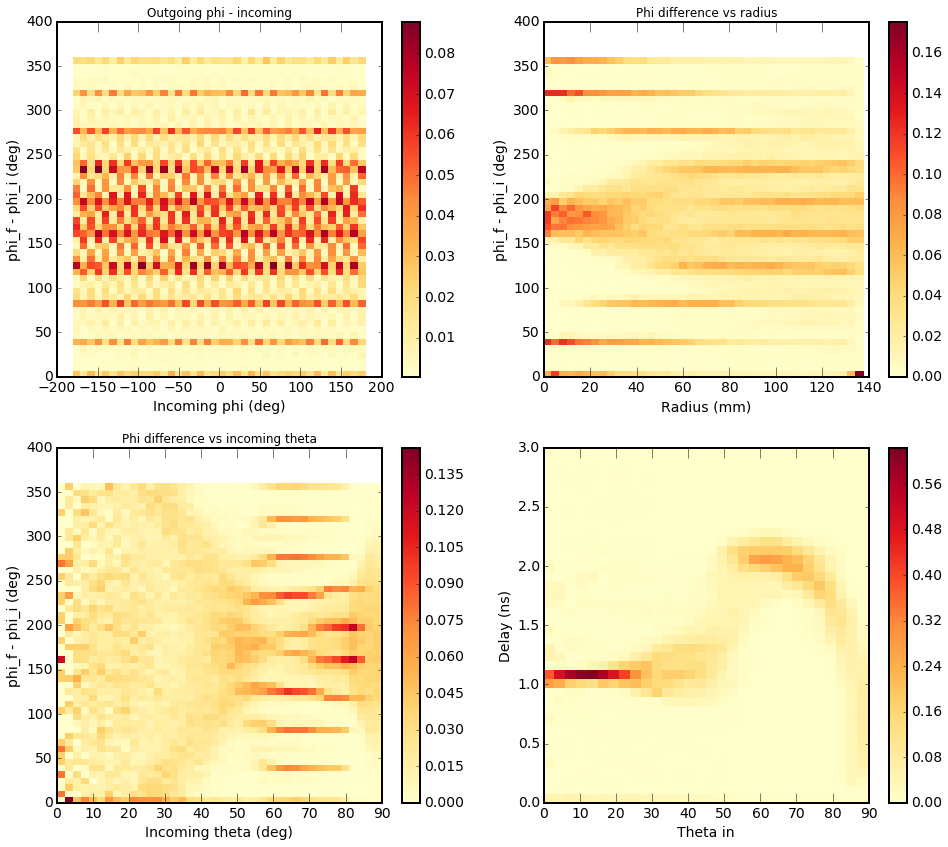

In [29]:
print 'Selecting only the events that hit the CONCENTRATOR and have multiple reflections reflection'
sel=( np.array([True]*len(data['y']))
     *reflect_conc
     *(data['nsteps'] >1)
     #*(data['z'] > 0)
     #*(data['r']>80)
    )
print 'Events ', np.sum(sel)
plotReflections(data,sel)